In [1]:
import numpy as np
import sys
import gsw
import xarray as xr
import numpy as np
from scipy import integrate
from copy import deepcopy 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from jmd95 import densjmd95

In [2]:
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [3]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v4'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

In [4]:
## Load 2D Monthly data...SSH 
data_dir= ECCO_dir + '/nctiles_monthly'
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                                           vars_to_load=['THETA','SALT','SSHDYN','OBPNOPAB'],\
                                           years_to_load=range(2011,2017)).load() # if desired, add after 'SSH','NEW_VAR',... 'SSH','OBP',                                           

## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))

loading files of  OBPNOPAB
loading files of  SALT
loading files of  SSHDYN
loading files of  THETA


In [5]:
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)

In [6]:
np.shape(ecco_monthly_ds.SALT) # [month, depth, tile, lat,lon]

(72, 50, 13, 90, 90)

In [7]:
H = ecco_monthly_ds.Depth 
z_star = ((ecco_monthly_ds.Z - ecco_monthly_ds.SSHDYN)/(H + ecco_monthly_ds.SSHDYN))*H

-5906.237
4325.282
-4264.2505


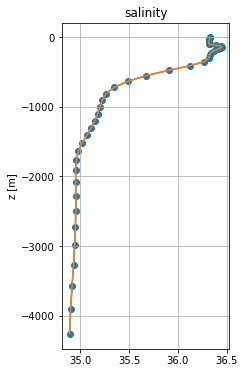

In [8]:
testloc = np.where((ecco_monthly_ds.YC > 33) & (ecco_monthly_ds.YC < 35) & (ecco_monthly_ds.XC > -45) & (ecco_monthly_ds.XC < -43))
test_salt = ecco_monthly_ds.SALT[0,:,testloc[0][0],testloc[1][0],testloc[2][0]]
test_salt = test_salt.where(test_salt>0, np.nan)
f, ax = plt.subplots(1,1,figsize=(3,6))
ax.plot(test_salt, z_star[:,0,testloc[0][0],testloc[1][0],testloc[2][0]])
ax.scatter(test_salt, z_star[:,0,testloc[0][0],testloc[1][0],testloc[2][0]])
ax.plot(test_salt, ecco_monthly_ds.Z)
ax.grid()
ax.set_title('salinity')
ax.set_ylabel('z [m]')

print(z_star[-1,0,testloc[0][0],testloc[1][0],testloc[2][0]].data)
print(H[testloc[0][0],testloc[1][0],testloc[2][0]].data)
print(z_star[np.where(np.isnan(test_salt))[0][0]-1,0,testloc[0][0],testloc[1][0],testloc[2][0]].data)

In [9]:
np.shape(ecco_monthly_ds.SALT)

(72, 50, 13, 90, 90)

In [10]:
# density using ECCO equation of state(?) 
p = gsw.p_from_z(ecco_monthly_ds.Z, ecco_monthly_ds.YC)
z = gsw.z_from_p(p, ecco_monthly_ds.YC)
salt = ecco_monthly_ds.SALT[0:24]
salt = salt.where(salt>0, np.nan)
rho_jmd95 = densjmd95(salt,ecco_monthly_ds.THETA[0:24],p)

In [11]:
salt = ecco_monthly_ds.SALT[24:48]
salt = salt.where(salt>0, np.nan)
rho_jmd95_2 = densjmd95(salt,ecco_monthly_ds.THETA[24:48],p)

In [12]:
salt = ecco_monthly_ds.SALT[48:]
salt = salt.where(salt>0, np.nan)
rho_jmd95_3 = densjmd95(salt,ecco_monthly_ds.THETA[48:],p)

In [13]:
rho_jmd95 = np.concatenate((rho_jmd95,rho_jmd95_2,rho_jmd95_3),axis=0)

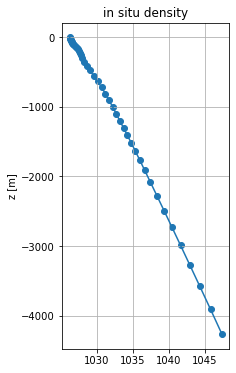

In [14]:
testloc = np.where((ecco_monthly_ds.YC > 33) & (ecco_monthly_ds.YC < 35) & (ecco_monthly_ds.XC > -45) & (ecco_monthly_ds.XC < -43))
f, ax = plt.subplots(1,1,figsize=(3,6))
ax.plot(rho_jmd95[0,:,testloc[0][0],testloc[1][0],testloc[2][0]], z[:,testloc[0][0],testloc[1][0],testloc[2][0]])
ax.scatter(rho_jmd95[0,:,testloc[0][0],testloc[1][0],testloc[2][0]], z[:,testloc[0][0],testloc[1][0],testloc[2][0]])
ax.set_title('in situ density')
ax.set_ylabel('z [m]')
ax.grid()

## Procedure
- calculaute in-situ density at each grid point for each month of time series 
- steric height = (1/ $\rho_0$ ) vertical sum of density anomalies * cell thickness ... (using drF and hFacC)

-179.0 179.0
-180.0 180.0
-89.0 89.0
-90.0 90.0


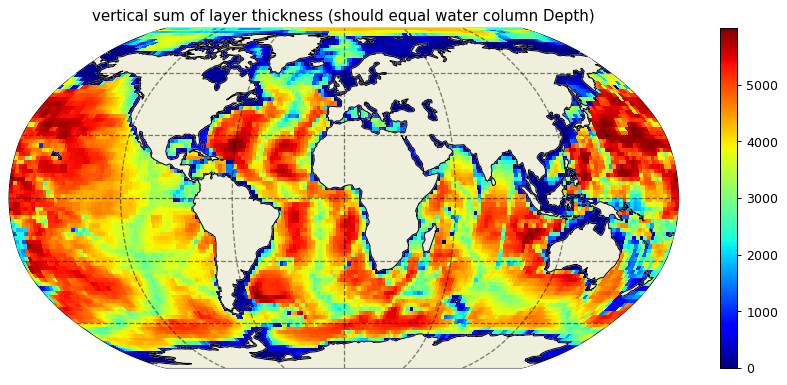

In [15]:
plt.figure(figsize=(12,5), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, np.sum(ecco_grid.hFacC*ecco_grid.drF, axis=0), \
                              user_lon_0=0,plot_type='pcolormesh',show_colorbar=True,dx=2,dy=2,cmap='jet');
plt.title('vertical sum of layer thickness (should equal water column Depth)');

In [28]:
np.shape(ecco_grid.hFacC)

(50, 13, 90, 90)

In [46]:
rho0 = 1035
# rho_pr_jmd_old = integrate.cumulative_trapezoid(rho_jmd95-rho0,x=np.tile(z, (np.shape(salt)[0],1,1,1,1)),axis=1)
rho_pr_jmd = np.nan*np.ones((np.shape(rho_jmd95)[0],np.shape(rho_jmd95)[2],np.shape(rho_jmd95)[3],np.shape(rho_jmd95)[4]))
for i in range(np.shape(rho_jmd95)[0]):
    rho_pr_jmd[i] = np.sum((rho_jmd95[i]-rho0)*ecco_grid.hFacC*ecco_grid.drF, axis=0)
steric_height_jmd = (-1/rho0)*rho_pr_jmd

In [47]:
steric_height_jmd_xr = xr.DataArray(
    data=steric_height_jmd,
    dims=["time","tile","j", "i"],
    coords=dict(
        i=(["i"], ecco_monthly_ds.SALT.i.data), j=(["j"], ecco_monthly_ds.SALT.j.data),
        XC=(["tile","j","i"], ecco_monthly_ds.SALT.XC.data), YC=(["tile","j","i"], ecco_monthly_ds.SALT.YC.data),
        tile=(["tile"], ecco_monthly_ds.SALT.tile.data), time=(["time"], ecco_monthly_ds.SALT.time.data),
    ),
)

In [48]:
# upper 1000m
rho_pr_jmd_1000 = np.nan*np.ones((np.shape(rho_jmd95)[0],np.shape(rho_jmd95)[2],np.shape(rho_jmd95)[3],np.shape(rho_jmd95)[4]))
for i in range(np.shape(rho_jmd95)[0]):
    rho_pr_jmd_1000[i] = np.sum((rho_jmd95[i][0:29]-rho0)*ecco_grid.hFacC[0:29]*ecco_grid.drF[0:29], axis=0)
steric_height_jmd_1000 = (-1/rho0)*rho_pr_jmd_1000
# deeper 
rho_pr_jmd_deep = np.nan*np.ones((np.shape(rho_jmd95)[0],np.shape(rho_jmd95)[2],np.shape(rho_jmd95)[3],np.shape(rho_jmd95)[4]))
for i in range(np.shape(rho_jmd95)[0]):
    rho_pr_jmd_deep[i] = np.sum((rho_jmd95[i][29:]-rho0)*ecco_grid.hFacC[29:]*ecco_grid.drF[29:], axis=0)
steric_height_jmd_deep = (-1/rho0)*rho_pr_jmd_deep

In [49]:
steric_height_jmd_1000_xr = xr.DataArray(
    data=steric_height_jmd_1000,
    dims=["time","tile","j", "i"],
    coords=dict(
        i=(["i"], ecco_monthly_ds.SALT.i.data), j=(["j"], ecco_monthly_ds.SALT.j.data),
        XC=(["tile","j","i"], ecco_monthly_ds.SALT.XC.data), YC=(["tile","j","i"], ecco_monthly_ds.SALT.YC.data),
        tile=(["tile"], ecco_monthly_ds.SALT.tile.data), time=(["time"], ecco_monthly_ds.SALT.time.data),
    ),
)
steric_height_jmd_deep_xr = xr.DataArray(
    data=steric_height_jmd_deep,
    dims=["time","tile","j", "i"],
    coords=dict(
        i=(["i"], ecco_monthly_ds.SALT.i.data), j=(["j"], ecco_monthly_ds.SALT.j.data),
        XC=(["tile","j","i"], ecco_monthly_ds.SALT.XC.data), YC=(["tile","j","i"], ecco_monthly_ds.SALT.YC.data),
        tile=(["tile"], ecco_monthly_ds.SALT.tile.data), time=(["time"], ecco_monthly_ds.SALT.time.data),
    ),
)

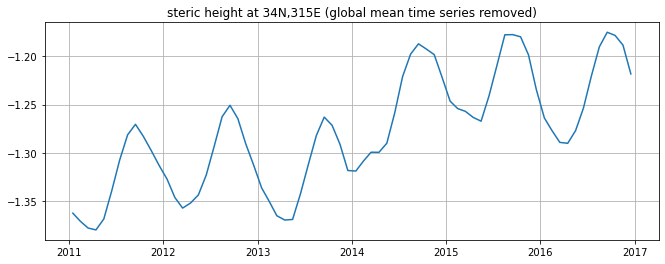

In [50]:
testloc = np.where((ecco_monthly_ds.YC > 33) & (ecco_monthly_ds.YC < 35) & (ecco_monthly_ds.XC > -45) & (ecco_monthly_ds.XC < -43))
months = ecco_monthly_ds.time
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask)
steric_height_global_mean = (steric_height_jmd_xr*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
steric_height_r = steric_height_jmd_xr - steric_height_global_mean
f, ax = plt.subplots(1,1,figsize=(11,4))
ax.plot(months, steric_height_r[:,testloc[0][0],testloc[1][0],testloc[2][0]])
ax.set_title('steric height at 34N,315E (global mean time series removed)') 
ax.grid()

In [51]:
# STERIC HEIGHT TREND
days_since_first_record = ((ecco_monthly_ds.time - ecco_monthly_ds.time[0])/(86400e9)).astype(int).values

sh_flat = np.reshape(steric_height_r.values, (len(steric_height_r.time), 13*90*90))
sh_flat[np.nonzero(np.isnan(sh_flat))] = 0
# slope is in m / day
sh_slope, sh_intercept = np.polyfit(days_since_first_record, sh_flat, 1)
# and reshape the slope result back to 13x90x90    
sh_slope_all = np.reshape(sh_slope, (13,90,90))

# upper 1000
steric_height_1000_global_mean = (steric_height_jmd_1000_xr*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
steric_height_r_1000 = steric_height_jmd_1000_xr - steric_height_1000_global_mean
sh_flat = np.reshape(steric_height_r_1000.values, (len(steric_height_r.time), 13*90*90))
sh_flat[np.nonzero(np.isnan(sh_flat))] = 0
sh_slope, sh_intercept = np.polyfit(days_since_first_record, sh_flat, 1)  
sh_slope_1000 = np.reshape(sh_slope, (13,90,90))
# deep
steric_height_deep_global_mean = (steric_height_jmd_deep_xr*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
steric_height_r_deep = steric_height_jmd_deep_xr - steric_height_deep_global_mean
sh_flat = np.reshape(steric_height_r_deep.values, (len(steric_height_r.time), 13*90*90))
sh_flat[np.nonzero(np.isnan(sh_flat))] = 0
sh_slope, sh_intercept = np.polyfit(days_since_first_record, sh_flat, 1)  
sh_slope_deep = np.reshape(sh_slope, (13,90,90))

sh_trend = xr.DataArray(
    data=sh_slope_all,
    dims=["tile","j", "i"],
    coords=dict(
        i=(["i"], np.arange(90)), j=(["j"], np.arange(90)),
        XC=(["tile","j","i"], steric_height_r.XC.data), YC=(["tile","j","i"], steric_height_r.YC.data),
        tile=(["tile"], np.arange(13)),
    ),
)
sh_1000_trend = xr.DataArray(
    data=sh_slope_1000,
    dims=["tile","j", "i"],
    coords=dict(
        i=(["i"], np.arange(90)), j=(["j"], np.arange(90)),
        XC=(["tile","j","i"], steric_height_r.XC.data), YC=(["tile","j","i"], steric_height_r.YC.data),
        tile=(["tile"], np.arange(13)),
    ),
)
sh_deep_trend = xr.DataArray(
    data=sh_slope_deep,
    dims=["tile","j", "i"],
    coords=dict(
        i=(["i"], np.arange(90)), j=(["j"], np.arange(90)),
        XC=(["tile","j","i"], steric_height_r.XC.data), YC=(["tile","j","i"], steric_height_r.YC.data),
        tile=(["tile"], np.arange(13)),
    ),
)

In [21]:
# rho_pr_ind = np.nan*np.ones(np.shape(rho_jmd95[:,0]))
# for m in range(np.shape(rho_jmd95)[0]):
#     print(m)
#     for k in range(np.shape(rho_jmd95)[2]):
#         for j in range(np.shape(rho_jmd95)[3]):
#             for i in range(np.shape(rho_jmd95)[4]):
#                 if ~np.isnan(ocean_mask[0,k,j,i]):
#                     this_rho_pr = rho_jmd95[m,:,k,j,i]-rho0
#                     good = np.where(~np.isnan(this_rho_pr))[0]
#                     rho_pr_ind[m,k,j,i] = integrate.cumulative_trapezoid(this_rho_pr[good], x=z[good,k,j,i].data)[-1]

In [11]:
# p_test = gsw.p_from_z(ecco_monthly_ds.Z, ecco_monthly_ds.YC)
# z_test = gsw.z_from_p(p_test, ecco_monthly_ds.YC)
# z_test = z_test.transpose('time','k','tile','j','i')
# this_salt_test = ecco_monthly_ds.SALT
# this_salt_test = this_salt_test.where(this_salt_test>0, np.nan)
# this_sa_test = gsw.SA_from_SP(this_salt_test, p_test, ecco_monthly_ds.XC, ecco_monthly_ds.YC)
# this_ct_test = gsw.CT_from_pt(this_sa_test, ecco_monthly_ds.THETA)
# rho_test = gsw.rho(this_sa_test, this_ct_test, p_test)
# rho0 = 1035
# rho_prime_int = integrate.cumtrapz(rho_test-rho0,z_test,axis=1)
# steric_height = (-1/rho0)*((np.tile(H, (np.shape(z_test)[0],1,1,1))+\
#                             ecco_monthly_ds.SSH)/np.tile(H, (np.shape(z_test)[0],1,1,1)))*rho_prime_int[:,0]

-179.5 179.5
-180.0 180.0
-89.5 89.5
-90.0 90.0


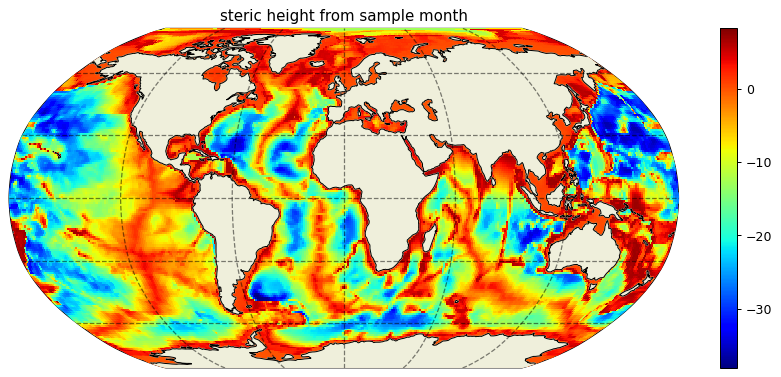

In [52]:
plt.figure(figsize=(12,5), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, steric_height_jmd_xr[5], \
                              user_lon_0=0,plot_type='pcolormesh',show_colorbar=True,dx=1,dy=1,cmap='jet');
plt.title('steric height from sample month');

0.5028032681564246 179.49720673184356
1e-05 180.0
-89.5 89.5
-90.0 90.0
-179.49720673184356 -0.5028032681564254
-180.0 -1e-05
-89.5 89.5
-90.0 90.0
0.5028032681564246 179.49720673184356
1e-05 180.0
-89.5 89.5
-90.0 90.0
-179.49720673184356 -0.5028032681564254
-180.0 -1e-05
-89.5 89.5
-90.0 90.0
0.5028032681564246 179.49720673184356
1e-05 180.0
-89.5 89.5
-90.0 90.0
-179.49720673184356 -0.5028032681564254
-180.0 -1e-05
-89.5 89.5
-90.0 90.0


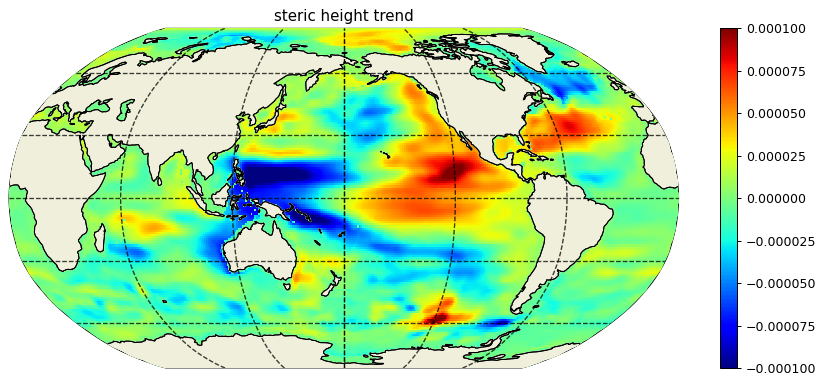

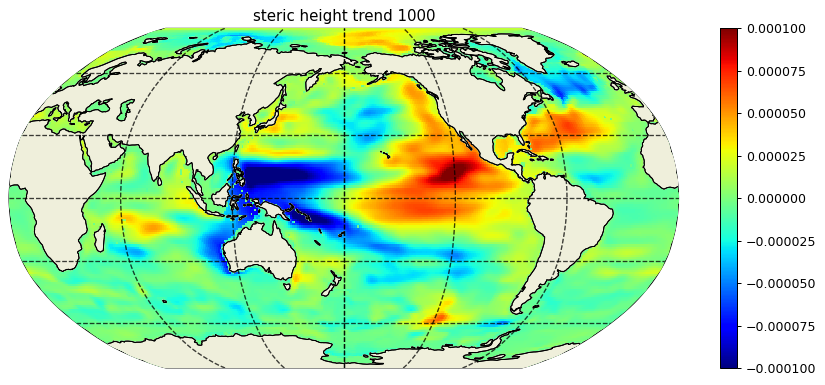

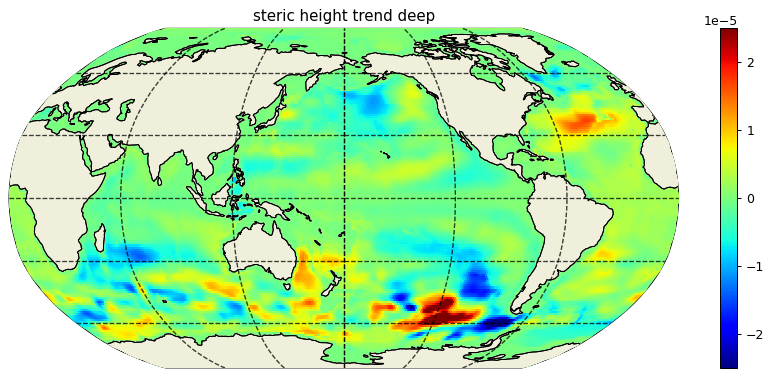

In [53]:
plt.figure(figsize=(12,5), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, sh_trend, \
                              user_lon_0=180,plot_type='pcolormesh',show_colorbar=True,dx=1,dy=1,cmap='jet',cmin=-0.0001,cmax=0.0001);
plt.title('steric height trend');
plt.figure(figsize=(12,5), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, sh_1000_trend, \
                              user_lon_0=180,plot_type='pcolormesh',show_colorbar=True,dx=1,dy=1,cmap='jet',cmin=-0.0001,cmax=0.0001);
plt.title('steric height trend 1000');
plt.figure(figsize=(12,5), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, sh_deep_trend, \
                              user_lon_0=180,plot_type='pcolormesh',show_colorbar=True,dx=1,dy=1,cmap='jet',cmin=-0.000025,cmax=0.000025);
plt.title('steric height trend deep');

In [35]:
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask[0,:])
steric_height_anom = steric_height_jmd_xr # - steric_height_jmd_xr.mean(dim=['tile','j','i'])
SH_global_mean_mon = (steric_height_anom*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
SH_global_mean_mon = SH_global_mean_mon # - SH_global_mean_mon.mean(dim='time')

In [40]:
SSHDYN_global_mean_mon = (ecco_monthly_ds.SSHDYN*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
SSHDYN_global_mean_mon = SSHDYN_global_mean_mon - SSHDYN_global_mean_mon.mean(dim=['time'])
OBP_global_mean_mon = ((ecco_monthly_ds.OBPNOPAB)*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
OBP_global_mean_mon = OBP_global_mean_mon - OBP_global_mean_mon.mean(dim=['time'])

# obp = ecco_monthly_ds.OBPNOPAB - ecco_monthly_ds.OBPNOPAB.mean(dim=['i','j','tile'])
# obp_global_mean = (obp*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area

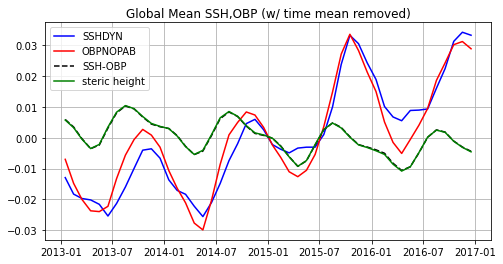

In [41]:
# SSHDYN_global_mean_mon.plot(color='r');
# OBP_global_mean_mon.plot(color='b');
f, (ax1) = plt.subplots(1,1,figsize=(8,4))
steric_height_check =  SSHDYN_global_mean_mon - OBP_global_mean_mon
ax1.plot(steric_height_check.time, SSHDYN_global_mean_mon, color='b', label='SSHDYN');
ax1.plot(steric_height_check.time, OBP_global_mean_mon, color='r', label='OBPNOPAB');
ax1.plot(steric_height_check.time, -1*steric_height_check, color='k', label='SSH-OBP', linestyle='--');
ax1.plot(steric_height_check.time, SH_global_mean_mon - SH_global_mean_mon.mean(dim='time'), color='g', label='steric height');
ax1.set_title('Global Mean SSH,OBP (w/ time mean removed)'); ax1.legend(); ax1.grid()